In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
path_raw    = '../data/raw/'
dirname     = 'titanic/'
filename    = 'titanic.csv'

## Load data

In [3]:
raw_df = pd.read_csv(os.path.join(path_raw, dirname, filename))

In [4]:
#raw_df.info()

In [5]:
print(raw_df.shape)
raw_df.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
features_type = {'qualitative': ['PassengerId', 
                                 #'Survived',
                                 'Pclass',
                                 'Name',
                                 'Sex',                                 
                                 'Ticket',
                                 'Cabin',
                                 'Embarked'
                                ],
                'quantitative': ['Age',
                                 'SibSp',
                                 'Parch',
                                 'Fare'
                                ]
                }

In [7]:
path_output = '../data/output/titanic/'

In [8]:
import sys
import os

sys.path.append('../src/')

from utils import log

from preprocessing import preprocess_data
from outlier_detection import detect_outliers
from statistical_analysis import statistical_analysis

class octopus_process:
    
    def __init__(self,
                 outliers_method,
                 alpha_sta,
                ):

        self.outliers_method = outliers_method
        self.alpha         = alpha_sta
        
        self.html = """<html><head>"""
        self.html += """<link rel = "stylesheet" href = "style.css"/>"""
        self.html += """</head><body><h1><center>Processing Report</center></h1>"""
        self.path_html = None
    
    def renderize_html(self):
        
        self.html += "<br></body></html>"

        with open(self.path_html, 'w') as out:
            out.write(self.html)
                
    def run(self, 
            data,
            y_name,
            features_type,
            path_output):
        
        self.path_html = os.path.join(path_output, 'report.html')
        logger = log(path_output, 'logs.txt')
        
        # Preprocess data        
        preprocess = preprocess_data(data           = data,
                                     y_name         = y_name,
                                     features_type  = features_type,
                                     html           = self.html,
                                     logger         = logger)

        X, y, features_type, html = preprocess.run()
        self.html = html
        
        # =================
        # Outlier detection
        detect_out = detect_outliers(X             = X,
                                     features_type = features_type,
                                     method        = self.outliers_method,
                                     logger        = logger)
        
        outliers = detect_out.run() 
        X = X[~outliers]
        y = y[~outliers]
        
        # HTML report about outliers
        if self.outliers_method == 'adjbox':
            name = 'Adjusted Boxplot for skewed distribution'
        elif self.outliers_method == 'lof':
            name = 'Local Outlier Factor (LOF)'
        elif self.outliers_method == 'isolation_forest':
            name = 'Isolarion Forest'
            
        str_ = name + " method used<br>Total outliers found: " + str(outliers.sum())
        self.html += "<h2><center>Outlier detection:</center></h2>"
        self.html += str_
        
        # =================
        # statistical analysis
        self.html += "<h2><center>Statistical Analysis:</center></h2>"
        
        sta = statistical_analysis(
                           X      = X, 
                           y      = y,
                           y_name = y_name,
                           features_type = features_type,
                           alpha  = self.alpha,
                           html   = self.html,
                           path_output = path_output,
                           logger = logger
                          )

        self.html = sta.run()
        # =================
        
        # Make the HTML file
        self.renderize_html()
        
        return X, y, features_type

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

class octopus_prepare:
    """
    A class to perform the data preparation. It has implemented three methods,
    two of them for split and transform data and one method that consolidate all.
    
    ...
    
    
    Attributes
    ----------
    seed : float
        Seed to be used in train and test split. Controls the shuffling applied 
        to the data before applying the split.
    method_scale : str
        Method to be used to transform or scale the data. Two methods are implemented
        "standard" for StandardScaler and "robust" for RobustScaler
    
    Methods
    -------
    split_data(X, y, features_type)
        Split the data in train and test sets, but before, it performs one hot encoding 
        for categorical features.
    scale_data(X_train, X_test, features_type)
        Transform the data in order with the method specified. 
        Two methods are supported StandardScaler and RobustScaler.
    run(X, y, features_type)
        Runs the split and scale data functions.
    """
    
    def __init__(self, seed, method_scale):
        
        self.SEED   = seed
        self.method = method_scale       
        
    def split_data(self, X, y, features_type):
        """
        This function splits the data in train and test sets, but before, it performs
        one hot encoding for categorical features
        
        Parameters
        ----------
        X : pd.DataFrame
            Pandas DataFrame to use. This one contains just X features
        y : pd.Series
            Variable of interest
        features_type : dict[str : list[str]]
            Dictionary that contains two keys: qualitatives and quantitatives. The values
            are the list of features names respectively.
            
        
        Return
        ------
        X_train : pd.DataFrame
            Pandas DataFrame to use in trainig. This one contains just X features
        X_test : pd.DataFrame
            Pandas DataFrame to use in test. This one contains just X features
        y_train : pd.Series
            Pandas Series to use in trainig. This one contains just the interest feature
        y_test : pd.Series
            Pandas Series to use in test. This one contains just the interest feature
        """
        
        X = pd.get_dummies(X, 
                           columns    = features_type['qualitative'],
                           drop_first = True)

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size = 0.25,
                                                            random_state = self.SEED)
        
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, features_type):
        """
        This function transform the data in order with the method specified.
        Two methods are supported StandardScaler and RobustScaler
        
        Parameters
        ----------
        X_train : pd.DataFrame
            Pandas DataFrame to use in trainig. This one contains just X features
        X_test : pd.DataFrame
            Pandas DataFrame to use in test. This one contains just X features
        features_type : dict[str : list[str]]
            Dictionary that contains two keys: qualitatives and quantitatives. The values
            are the list of features names respectively.
        
        Return
        ------
        X_train : pd.DataFrame
            Training set scaled
        X_test : pd.DataFrame
            Test set scaled
        """
        
        if self.method == 'standard':
            scaler = StandardScaler()
        elif self.method == 'robust':
            scaler = RobustScaler()
        else:
            print('Invalid method scaler')
        
        X_train[features_type['quantitative']] = scaler.fit_transform(X_train[features_type['quantitative']])
        X_test[features_type['quantitative']] = scaler.transform(X_test[features_type['quantitative']])
        
        return X_train, X_test
    
    def run(self, X, y, features_type):
        """
        This function runs the split and scale data functions.
        
        split_data: split the data in train and test sets, but before, it performs
        one hot encoding for categorical features.
        
        scale_data: transform the data in order with the method specified.
        Two methods are supported (standard) StandardScaler and (robust) RobustScaler
        """
        X_train, X_test, y_train, y_test = self.split_data(X = X,
                                                           y = y,
                                                           features_type = features_type
                                                           )
        
        X_train, X_test = self.scale_data(X_train, X_test, features_type)
        
        return X_train, X_test, y_train, y_test

In [10]:
# Modeling
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from utils import rfc_cv
from utils import xgb_cv

class octopus_train:
    
    def __init__(self, seed, metric, njobs):
        
        self.SEED = seed
        self.metric = metric
        self.njobs = njobs
    
    def logistic_regression(self, X_train, y_train):
        """
        Logistic Regression without regularization
        """
        lr = LogisticRegression(C = 1e6,
                                max_iter = 500,
                                random_state = self.SEED)
        lr.fit(X_train, y_train)
        
        return lr
    
    def regularized_logistic_regression(self, X_train, y_train):
        """
        Logistic Regression with regularization
        """

        lrr = LogisticRegression(max_iter = 500,
                                 random_state = self.SEED)        

        grid = {'C': [1000, 100, 10, 1, 0.1, 0.08, 0.02, 0.001, 0.0001, 0.015, 0.0001]}

        grid_search = GridSearchCV(estimator = lrr, 
                                   param_grid = grid, 
                                   n_jobs = self.njobs,
                                   scoring = self.metric
                                   )

        grid_search.fit(X_train, y_train)
        
        return grid_search.best_estimator_
    
    # Definition optimizer for random Forest
    def optimize_rfc(self,
                     X_train, 
                     y_train,
                     metric
                    ):
        """
        Apply Bayesian Optimization to Random Forest parameters.
        """
        def rfc_crossval(n_estimators, 
                         max_depth,
                         min_samples_split,
                         min_samples_leaf,
                         max_features):
            """
            Wrapper of RandomForest cross validation.
            Notice how we ensure n_estimators and min_samples_split are casted
            to integer before we pass them along. Moreover, to avoid max_features
            taking values outside the (0, 1) range, we also ensure it is capped
            accordingly.
            """
            val = rfc_cv(
                        n_estimators      = int(round(n_estimators)),
                        max_depth         = int(round(max_depth)),
                        min_samples_split = int(round(min_samples_split)),
                        min_samples_leaf  = int(round(min_samples_leaf)),
                        max_features      = max(min(max_features, 0.999), 1e-3),
                        metric = metric,
                        X = X_train,
                        y = y_train,
                       )
            return val

        hyp_space = {"n_estimators" : (50, 500),
                     "max_depth"    : (2, 10),
                     "min_samples_split": (15, 100),
                     "min_samples_leaf" : (5, 50),
                     "max_features": (0.1, 0.999)
                    }
                        
        optimizer = BayesianOptimization(
                            f            = rfc_crossval,
                            pbounds      = hyp_space,
                            random_state = self.SEED,
                            verbose      = 0)

        optimizer.maximize(init_points = 20, n_iter = 50)

        return optimizer.max
    
    # Definition Optimizer for XGBoost
    def optimize_xgb(self,
                     X_train, 
                     y_train,
                     metric
                    ):
        """
        Apply Bayesian Optimization to Random Forest parameters.
        """
        def xgb_crossval(n_estimators,
                         max_depth,
                         colsample_bytree,
                         eta):
            """
            Wrapper of XGBoost cross validation.
            Notice how we ensure some parameters are casted o integer before we pass them along. 
            Moreover, to avoid others taking values outside the (0, 1) range, 
            we also ensure it is capped accordingly.
            """
            val = xgb_cv(
                        n_estimators      = int(round(n_estimators)),
                        max_depth         = int(round(max_depth)),
                        colsample_bytree  = max(min(colsample_bytree, 0.999), 1e-3),
                        learning_rate     = max(min(eta, 0.999), 1e-3),
                        metric = metric,
                        X      = X_train,
                        y      = y_train,
                       )
            return val

        hyp_space = {"n_estimators" : (50, 500),
                     "max_depth"    : (2, 10),
                     "colsample_bytree": (0.1, 0.999),
                     "eta" : (0.001, 0.4)}
                        
        optimizer = BayesianOptimization(
                            f            = xgb_crossval,
                            pbounds      = hyp_space,
                            random_state = self.SEED,
                            verbose      = 0)

        optimizer.maximize(init_points = 20, n_iter = 50)

        return optimizer.max
    
    def run(self, X_train, y_train):
        
        lr  = self.logistic_regression(X_train, y_train)
        lrr = self.regularized_logistic_regression(X_train, y_train)
        
        # Random Forest tuning
        opt_rf = self.optimize_rfc(X_train,
                                   y_train,
                                   metric = self.metric)        
        best_hyp_rf = {
               'max_depth'         : int(round(opt_rf['params']['max_depth'])),
               'max_features'      : opt_rf['params']['max_features'],
               'min_samples_leaf'  : int(round(opt_rf['params']['min_samples_leaf'])),
               'min_samples_split' : int(round(opt_rf['params']['min_samples_split'])),
               'n_estimators'      : int(round(opt_rf['params']['n_estimators'])),
               'random_state'      : self.SEED
              }
        rf = RandomForestClassifier(**best_hyp_rf)
        rf.fit(X_train, y_train)
        # Finish tuning Random Forest
        
        # XGBoost classifier tuning       
        opt_xgb = self.optimize_xgb(X_train,
                                    y_train,
                                    metric = self.metric)
        
        PARAM_SCALE_POS = np.ceil( len(y_train[y_train == 0]) / len(y_train[y_train == 1]) )
        
        best_hyp_xgb = {
               'max_depth'        : int(round(opt_xgb['params']['max_depth'])),
               'colsample_bytree' : opt_xgb['params']['colsample_bytree'],
               'n_estimators'     : int(round(opt_xgb['params']['n_estimators'])),
               'learning_rate'    : max(min(opt_xgb['params']['eta'], 0.999), 1e-3),
               'objective'        : 'binary:logistic',
               'scale_pos_weight' : PARAM_SCALE_POS,
               'random_state'     : self.SEED,
               'verbosity'        : 0
              }
        xgb_cl = xgb.XGBClassifier(**best_hyp_xgb)
        xgb_cl.fit(X_train, y_train)
        # Finish tuning XGBoost classifier
        
        models = [('LR', lr),
                  ('LRR', lrr),
                  ('RF', rf),
                  ('XGB', xgb_cl)
                 ]
        
        return models

In [11]:
# process data, data cleaning
octo_process = octopus_process(outliers_method = 'lof',
                               alpha_sta     = 0.05)

X, y, features_type = octo_process.run(
                                    data          = raw_df,
                                    y_name        = 'Survived',
                                    features_type = features_type,
                                    path_output   = path_output)

2021-05-16 16:21:39,847 INFO: Started to check the features consistency
2021-05-16 16:21:39,880 INFO: Features: ['PassengerId', 'Name', 'Ticket', 'Cabin'] were removed because its distribution
2021-05-16 16:21:39,881 INFO: Consistency values finished!
2021-05-16 16:21:39,889 INFO: Feature Age was imputer with the method median value = 28.0
2021-05-16 16:21:39,893 INFO: Feature Embarked was imputer with "other"
2021-05-16 16:21:39,894 INFO: None feature were removed because the missing values
2021-05-16 16:21:39,895 INFO: Handle missing values finished!
2021-05-16 16:21:39,897 INFO: Detect outliers started
2021-05-16 16:21:39,899 INFO: Local Outlier Factor method selected
2021-05-16 16:21:39,926 INFO: Detected 146 outliers
2021-05-16 16:21:39,928 INFO: Detect outliers finished


<Figure size 432x288 with 0 Axes>

In [12]:
# data preparation for model
octo_prepare = octopus_prepare(seed = 42,
                               method_scale = 'standard')

X_train, X_test, y_train, y_test = octo_prepare.run(X = X,
                                                    y = y,
                                                    features_type = features_type)

In [13]:
# modeling
octo_train = octopus_train(seed = 42,
                           metric = 'accuracy',
                           njobs = -1)

models_trained = octo_train.run(X_train, y_train)

In [14]:
models_trained

[('LR', LogisticRegression(C=1000000.0, max_iter=500, random_state=42)),
 ('LRR', LogisticRegression(C=0.1, max_iter=500, random_state=42)),
 ('RF',
  RandomForestClassifier(max_depth=8, max_features=0.37384777848686024,
                         min_samples_leaf=9, min_samples_split=73,
                         n_estimators=248, random_state=42)),
 ('XGB',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.7439419453116151, gamma=0,
                gpu_id=-1, importance_type='gain', interaction_constraints='',
                learning_rate=0.021939320923203304, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=129, n_jobs=8, num_parallel_tree=1, random_state=42,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=2.0, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=0))]

In [34]:
# evaluate
from utils import evaluate
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

class octopus_evaluate:
    
    def __init__(self, metric, seed):
        
        self.metric = metric
        self.SEED   = seed
        self.metric_list = ['accuracy', 
                            'recall',
                            'precision',
                            'f1'
                           ]
    
    def run(self, X_train, y_train, models_trained):
        
        # evaluate each model in turn
        results = []
        results_avg = []
        results_std = []
        names = []

        for name, model in models_trained:
            
            kfold = KFold(n_splits = 10, 
                          shuffle = True,
                          random_state = self.SEED)
            
            cv_results = cross_val_score(model, 
                                         X_train, 
                                         y_train, 
                                         cv = kfold, 
                                         scoring = self.metric)
            results.append(cv_results)
            names.append(name)
            
            results_avg.append(cv_results.mean())
            results_std.append(cv_results.std())
            
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

        # Best model
        ixmax = np.array(results_avg).argmax()
        best_name = names[ixmax]
        
        # boxplot algorithm comparison
        fig = plt.figure()
        fig.suptitle('Algorithm Comparison')
        ax = fig.add_subplot(111)
        plt.boxplot(results)
        plt.title('Using the ' + self.metric + ' metric, the best model is ' + best_name)
        plt.ylabel(self.metric.capitalize())
        ax.set_xticklabels(names)
        plt.show()       
                
        return None

LR: 0.762015 (0.074992)
LRR: 0.705910 (0.070878)
RF: 0.799083 (0.050747)
XGB: 0.830560 (0.059204)


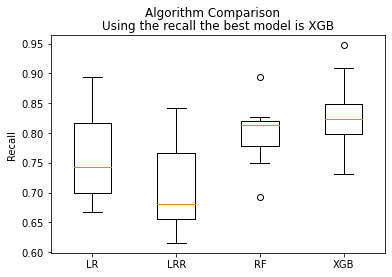

'XGB'

In [35]:
octo_eval = octopus_evaluate(metric = 'recall', seed = 42)
octo_eval.run(X_train, y_train, models_trained)

In [25]:
for name_model in models_trained:
    model = name_model[1]
    print(evaluate(X_train, y_train, model))
    print('# =============================== #')

{'recall': 0.7702127659574468, 'precision': 0.7735042735042735, 'f1': 0.7718550106609808, 'accuracy': 0.8082437275985663, 'auc': 0.8821685000988077}
# =============================== #
{'recall': 0.7191489361702128, 'precision': 0.8047619047619048, 'f1': 0.7595505617977529, 'accuracy': 0.8082437275985663, 'auc': 0.881733746130031}
# =============================== #
{'recall': 0.8127659574468085, 'precision': 0.8059071729957806, 'f1': 0.809322033898305, 'accuracy': 0.8387096774193549, 'auc': 0.9116263750741058}
# =============================== #
{'recall': 0.9191489361702128, 'precision': 0.864, 'f1': 0.8907216494845361, 'accuracy': 0.9050179211469535, 'auc': 0.9672353599894605}
# =============================== #


In [24]:
for name_model in models_trained:
    model = name_model[1]
    print(evaluate(X_test, y_test, model))
    print('# =============================== #')

{'recall': 0.7407407407407407, 'precision': 0.5714285714285714, 'f1': 0.6451612903225806, 'accuracy': 0.7647058823529411, 'auc': 0.8143971038707881}
# =============================== #
{'recall': 0.6851851851851852, 'precision': 0.6271186440677966, 'f1': 0.6548672566371682, 'accuracy': 0.7914438502673797, 'auc': 0.8050682261208577}
# =============================== #
{'recall': 0.7222222222222222, 'precision': 0.5416666666666666, 'f1': 0.619047619047619, 'accuracy': 0.7433155080213903, 'auc': 0.8184349763297132}
# =============================== #
{'recall': 0.7592592592592593, 'precision': 0.5324675324675324, 'f1': 0.6259541984732824, 'accuracy': 0.7379679144385026, 'auc': 0.8373015873015873}
# =============================== #
